In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import joblib

In [ ]:
CSV_PATH = "..\\data\data_sets\\training_data\Reddit_Data.csv"  
TEXT_COL = "clean_comment"              
LABEL_COL = "category"         
RANDOM_STATE = 42


df = pd.read_csv(CSV_PATH)

# Keep only relevant columns + drop missing
df = df[[TEXT_COL, LABEL_COL]].dropna().copy()
df[TEXT_COL] = df[TEXT_COL].astype(str).str.strip()

# Keep only valid labels
allowed = {-1, 0, 1}
df = df[df[LABEL_COL].isin(allowed)].copy()


X = df[TEXT_COL].values
y = df[LABEL_COL].values

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

In [4]:
# Evaluation + Confusion Matrix
def evaluate_model(model, X_eval, y_eval, title="Confusion Matrix"):
    y_pred = model.predict(X_eval)
    print(classification_report(y_eval, y_pred, digits=4))
    cm = confusion_matrix(y_eval, y_pred, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
    plt.figure(figsize=(5, 5))
    disp.plot(values_format="d")
    plt.title(title)
    plt.show()
    return y_pred

# Negation-safe stopwords
#    Default ENGLISH_STOP_WORDS may remove "not", "no", etc.
NEGATIONS = {"no", "nor", "not", "never", "cannot", "can't", "won't", "don't", "didn't", "isn't", "aren't"}
custom_stopwords = sorted(list(set(ENGLISH_STOP_WORDS) - {"no", "nor", "not", "never", "cannot"}))


In [5]:
# Character TF-IDF + LinearSVC (tuned)
# Often improves robustness to slang/typos/short texts
char_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char_wb",
        lowercase=True,
        sublinear_tf=True,
        max_features=200000
    )),
    ("clf", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))
])

char_param_grid = {
    "tfidf__ngram_range": [(3, 5), (4, 6)],
    "tfidf__min_df": [3, 5],
    "tfidf__max_df": [0.95, 1.0],
    "clf__C": [0.25, 0.5, 1.0],
}

char_search = GridSearchCV(
    estimator=char_pipe,
    param_grid=char_param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("\nTuning CHAR TF-IDF + LinearSVC")
char_search.fit(X_train, y_train)

print("\nBest CHAR CV macro-F1:", char_search.best_score_)
print("Best CHAR params:", char_search.best_params_)
best_char = char_search.best_estimator_



Tuning CHAR TF-IDF + LinearSVC
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best CHAR CV macro-F1: 0.8651764971927349
Best CHAR params: {'clf__C': 1.0, 'tfidf__max_df': 0.95, 'tfidf__min_df': 5, 'tfidf__ngram_range': (4, 6)}


In [6]:
# Evaluation + Confusion Matrix
def evaluate_model(model, X_eval, y_eval, title="Confusion Matrix"):
    y_pred = model.predict(X_eval)
    print(classification_report(y_eval, y_pred, digits=4))
    cm = confusion_matrix(y_eval, y_pred, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
    plt.figure(figsize=(5, 5))
    disp.plot(values_format="d")
    plt.title(title)
    plt.show()
    return y_pred

# Negation-safe stopwords
#    Default ENGLISH_STOP_WORDS may remove "not", "no", etc.
NEGATIONS = {"no", "nor", "not", "never", "cannot", "can't", "won't", "don't", "didn't", "isn't", "aren't"}
custom_stopwords = sorted(list(set(ENGLISH_STOP_WORDS) - {"no", "nor", "not", "never", "cannot"}))


In [7]:
# Word TF-IDF + LinearSVC (tuned)
word_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words=custom_stopwords,  # keep key negations
        max_features=100000           # helps stability + speed
    )),
    ("clf", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))
])

word_param_grid = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [2, 5],
    "tfidf__max_df": [0.90, 0.95],
    "tfidf__sublinear_tf": [True],
    "clf__C": [0.25, 0.5, 1.0],
}

word_search = GridSearchCV(
    estimator=word_pipe,
    param_grid=word_param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)
print("\nTuning WORD TF-IDF + LinearSVC")
word_search.fit(X_train, y_train)

print("\nBest WORD CV macro-F1:", word_search.best_score_)
print("Best WORD params:", word_search.best_params_)
best_word = word_search.best_estimator_


Tuning WORD TF-IDF + LinearSVC
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best WORD CV macro-F1: 0.8206073383584439
Best WORD params: {'clf__C': 0.5, 'tfidf__max_df': 0.9, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1), 'tfidf__sublinear_tf': True}


In [8]:
# Character TF-IDF + LinearSVC (tuned)
# Often improves robustness to slang/typos/short texts
char_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char_wb",
        lowercase=True,
        sublinear_tf=True,
        max_features=200000
    )),
    ("clf", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))
])

char_param_grid = {
    "tfidf__ngram_range": [(3, 5), (4, 6)],
    "tfidf__min_df": [3, 5],
    "tfidf__max_df": [0.95, 1.0],
    "clf__C": [0.25, 0.5, 1.0],
}

char_search = GridSearchCV(
    estimator=char_pipe,
    param_grid=char_param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("\nTuning CHAR TF-IDF + LinearSVC")
char_search.fit(X_train, y_train)

print("\nBest CHAR CV macro-F1:", char_search.best_score_)
print("Best CHAR params:", char_search.best_params_)
best_char = char_search.best_estimator_


Tuning CHAR TF-IDF + LinearSVC
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best CHAR CV macro-F1: 0.8651764971927349
Best CHAR params: {'clf__C': 1.0, 'tfidf__max_df': 0.95, 'tfidf__min_df': 5, 'tfidf__ngram_range': (4, 6)}



Selected best model: CHAR TF-IDF + LinearSVC (CV macro-F1=0.8652)

=== TEST SET PERFORMANCE
              precision    recall  f1-score   support

          -1     0.8284    0.7873    0.8073      1655
           0     0.8985    0.9467    0.9220      2609
           1     0.9028    0.8863    0.8945      3166

    accuracy                         0.8855      7430
   macro avg     0.8766    0.8734    0.8746      7430
weighted avg     0.8847    0.8855    0.8847      7430



<Figure size 500x500 with 0 Axes>

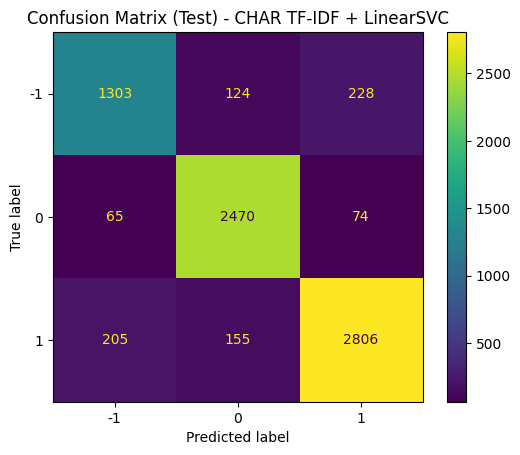

In [9]:
# Pick the better model by CV macro-F1
if char_search.best_score_ > word_search.best_score_:
    best_model = best_char
    best_name = "CHAR TF-IDF + LinearSVC"
    best_cv = char_search.best_score_
else:
    best_model = best_word
    best_name = "WORD TF-IDF + LinearSVC"
    best_cv = word_search.best_score_

print(f"\nSelected best model: {best_name} (CV macro-F1={best_cv:.4f})")


# Final evaluation on held-out TEST set
print("\n=== TEST SET PERFORMANCE")
y_test_pred = evaluate_model(best_model, X_test, y_test, title=f"Confusion Matrix (Test) - {best_name}")

# Error analysis: show confident wrong predictions
#     For LinearSVC, decision_function provides margins (confidence proxy).
def most_confident_mistakes(model, X_eval, y_true, n=25):
    # scores shape: (n_samples, n_classes)
    scores = model.decision_function(X_eval)
    # predicted class index (in model.classes_ order)
    pred_idx = np.argmax(scores, axis=1)
    y_pred = model.classes_[pred_idx]

    # confidence proxy: gap between top score and runner-up score
    sorted_scores = np.sort(scores, axis=1)
    margin = sorted_scores[:, -1] - sorted_scores[:, -2]

    mistakes = (y_pred != y_true)
    idx = np.where(mistakes)[0]

    out = pd.DataFrame({
        "text": X_eval[idx],
        "true": y_true[idx],
        "pred": y_pred[idx],
        "margin": margin[idx],
    }).sort_values("margin", ascending=False)

    return out.head(n)




In [10]:
mistakes_df = most_confident_mistakes(best_model, X_test, y_test, n=20)
print("\n=== Most confident mistakes (top 20) ===")
pd.set_option("display.max_colwidth", 160)
display(mistakes_df)

# Save the final pipeline
joblib.dump(best_model, "sentiment_best_model.joblib")
print("\nSaved model to sentiment_best_model.joblib")

# Reload test (optional)
loaded = joblib.load("sentiment_best_model.joblib")
print("Reload OK. Sample prediction:", loaded.predict(["I love this!", "I hate this.", "Meh."]))


=== Most confident mistakes (top 20) ===


,text,true,pred,margin
365,not cool,-1,1,3.688672
96,that fucking massive,0,-1,3.213202
606,could think that impairs the recipe for the guru thing curry range from their sales are forewarning you never gonna happen your logical debating skills man ...,0,1,2.974688
383,not fair,-1,1,2.963894
153,not shocking really,1,-1,2.847884
54,not long before the hand that feeds you gets bitten,1,-1,2.840834
523,this low not new for him,-1,1,2.795617
776,not sure the pak army wants release him like wanted,-1,1,2.773823
574,the hardest part really starting you feel like you have carve out time and worry about not doing the right way find place and time start preferably keep tha...,-1,1,2.618959
562,country corrupt this not even surprising,1,-1,2.454768



Saved model to sentiment_best_model.joblib
Reload OK. Sample prediction: [ 1 -1  0]
